# [Exploration 14] 폐렴 진단기 성능개선
## 프로젝트 설명 
---
DCGAN을 이용해 CIFAR-10 이미지를 생선하는 프로젝트


## 프로젝트 정리     
---        
1. 실험환경 set-up
2. 데이터 준비하기
3. 데이터 시각화 
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련 
7. 결과 확인과 시각화


## 프로젝트 목표
---



## 01. 실험환경 set-up (하이퍼 파라미터 설정)

In [77]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 데이터 로드시 빠르게 로드할 수 있습니다.
ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')

BATCH_SIZE = 16
IMAGE_SIZE = [180, 180]
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj26/aiffel


## 02. 데이터 준비하기
- 데이터를 가져옵니다.

In [79]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


**validation 데이터 갯수가 너무 없기 때문에 비율을 조정합니다.**
- train, val을 합쳐준 후, 8:2로 나누겠습니다.

In [80]:
filenames = tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 해당 데이터는 train, test, val 각 안에 정상, 폐렴 폴더로 라벨링이 되어있습니다.
- 정상, 폐렴 수를 확인하겠습니다.

In [81]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print('Normal images count in training set :', str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('Pneumonia images count in training set :', str(COUNT_PNEUMONIA))

Normal images count in training set : 1082
Pneumonia images count in training set : 3103


- 데이터의 불균형이 보입니다. (이는 차후에 조정하겠습니다.)


- 배치처리 효율화를 위해 tf.data인스턴스를 생성합니다.

In [82]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [83]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Training images count:', str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validating images count:', str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


**데이터 갯수 확인으로 tf.data인스턴스가 잘 생성되었음을 확인했습니다.**

In [84]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item in tf.io.gfile.glob(str(ROOT_PATH+'/chest_xray/train/*'))])

print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


- 이미지에 라벨을 붙이는 함수를 생성합니다.

In [85]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

- 데이터의 사이즈를 위에서 정한 사이즈로 줄여줍니다.
- tf.image.decode_jpeg : JPEG 인코딩된 이미지를 uint8 tensor로 디코딩하는 함수

In [86]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [87]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [88]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 라벨과 사이즈를 확인해보겠습니다.

In [89]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  True


- test set에도 적용하겠습니다.

In [90]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH+'/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [69]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # buffersize는 유지하되 그 안에서 shuffle
    ds = ds.repeat() # epoch에 맞게 필요한 만큼 데이터를 반복해서 수를 맞춰줍니다.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 03. 데이터 시각화

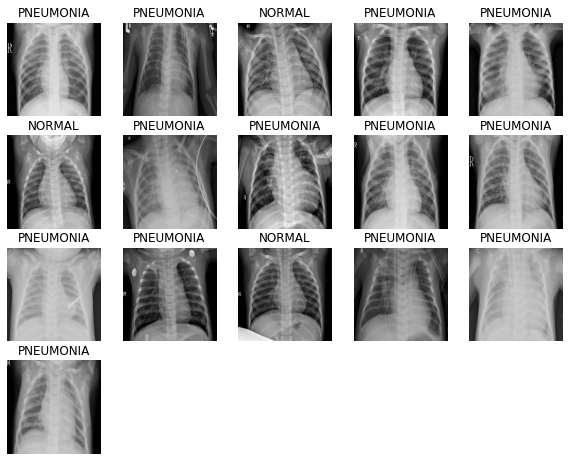

In [70]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

## 04. CNN 모델링
- convolution block, dense block으로 나누어 만듭니다.
- batch normalization, dropout을 동시에 사용합니다.

In [38]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [35]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

## 05. 데이터 불균형 처리
- Weight balancing 테크닉 사용
    - 클래스 별 가중치를 세팅해 불균형을 상쇄시킵니다.
    - weights는 데이터 건수에 반비례하도록 설정합니다.

In [33]:
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0:weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


## 06. 모델 훈련

In [40]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 99ms/step - loss: 0.3746 - accuracy: 0.8235 - precision: 0.9497 - recall: 0.8060 - val_loss: 0.8567 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 86ms/step - loss: 0.2305 - accuracy: 0.9114 - precision: 0.9709 - recall: 0.9085 - val_loss: 1.5545 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1996 - accuracy: 0.9241 - precision: 0.9755 - recall: 0.9213 - val_loss: 0.1607 - val_accuracy: 0.9356 - val_precision: 0.9198 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1877 - accuracy: 0.9310 - precision: 0.9771 - recall: 0.9294 - val_loss: 0.0934 - val_accuracy: 0.9731 - val_precision: 0.9841 - val_recall: 0.9789
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.2025 - accuracy: 0

## 07. 결과확인 및 시각화

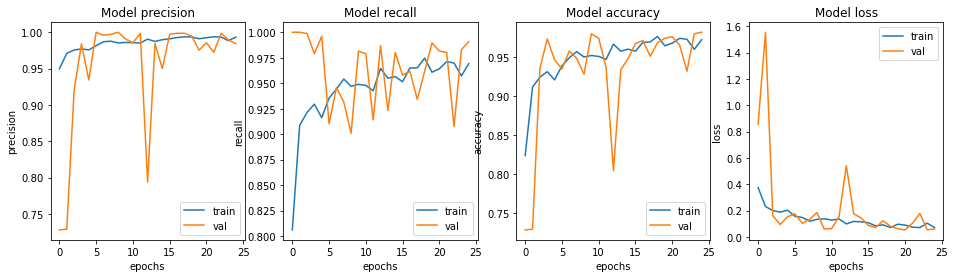

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 1.1693 - accuracy: 0.7388 - precision: 0.7060 - recall: 0.9974


## 08. 성능 개선
- data augmentation을 이용합니다.

In [91]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # data augmentation 과정 추가
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds_a = prepare_for_training(train_ds)
val_ds_a = prepare_for_training(val_ds)

print(train_ds_a)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


- 실제 좌우반전이 되었는지 확인합니다.

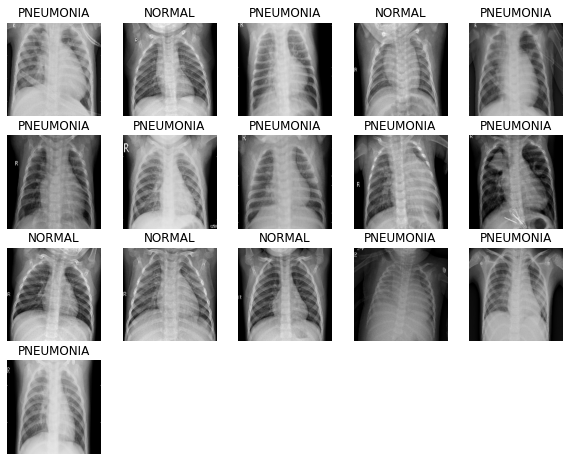

In [53]:
show_batch(image_batch.numpy(), label_batch.numpy())

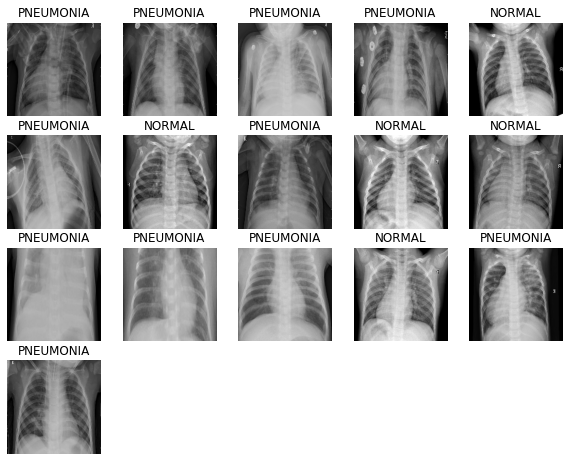

In [92]:
image_batch, label_batch = next(iter(train_ds_a))
show_batch(image_batch.numpy(), label_batch.numpy())

In [93]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)    # dropout을 제거해보겠습니다.
    ])
    return block

In [100]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [101]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [103]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_a,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_a,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 25s 98ms/step - loss: 0.3304 - accuracy: 0.8424 - precision: 0.9593 - recall: 0.8223 - val_loss: 0.6498 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 25s 96ms/step - loss: 0.2417 - accuracy: 0.9068 - precision: 0.9711 - recall: 0.9012 - val_loss: 1.4330 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 24s 94ms/step - loss: 0.2110 - accuracy: 0.9217 - precision: 0.9750 - recall: 0.9181 - val_loss: 0.2172 - val_accuracy: 0.9087 - val_precision: 0.8981 - val_recall: 0.9897
Epoch 4/30
261/261 [==============================] - 25s 94ms/step - loss: 0.1799 - accuracy: 0.9325 - precision: 0.9776 - recall: 0.9301 - val_loss: 0.0971 - val_accuracy: 0.9663 - val_precision: 0.9817 - val_recall: 0.9729
Epoch 5/30
261/261 [==============================] - 24s 92ms/step - loss: 0.1871 - accuracy: 0

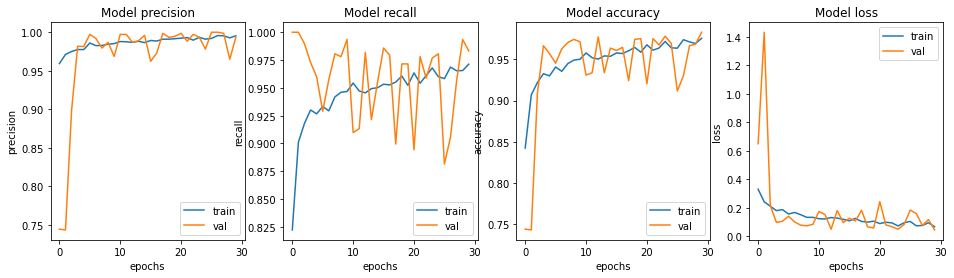

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [105]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 64ms/step - loss: 1.1469 - accuracy: 0.7692 - precision: 0.7321 - recall: 0.9949


In [106]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)    # dropout을 사용합니다.
    ])
    return block

In [107]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [108]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [110]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_a,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_a,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 25s 97ms/step - loss: 0.2283 - accuracy: 0.9107 - precision: 0.9716 - recall: 0.9060 - val_loss: 1.1548 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 25s 96ms/step - loss: 0.2007 - accuracy: 0.9253 - precision: 0.9774 - recall: 0.9206 - val_loss: 0.3598 - val_accuracy: 0.8490 - val_precision: 0.8317 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 24s 92ms/step - loss: 0.1853 - accuracy: 0.9279 - precision: 0.9781 - recall: 0.9234 - val_loss: 0.0663 - val_accuracy: 0.9779 - val_precision: 0.9908 - val_recall: 0.9793
Epoch 4/30
261/261 [==============================] - 24s 92ms/step - loss: 0.1864 - accuracy: 0.9279 - precision: 0.9801 - recall: 0.9217 - val_loss: 0.1520 - val_accuracy: 0.9452 - val_precision: 0.9337 - val_recall: 0.9974
Epoch 5/30
261/261 [==============================] - 24s 91ms/step - loss: 0.1557 - accuracy: 0

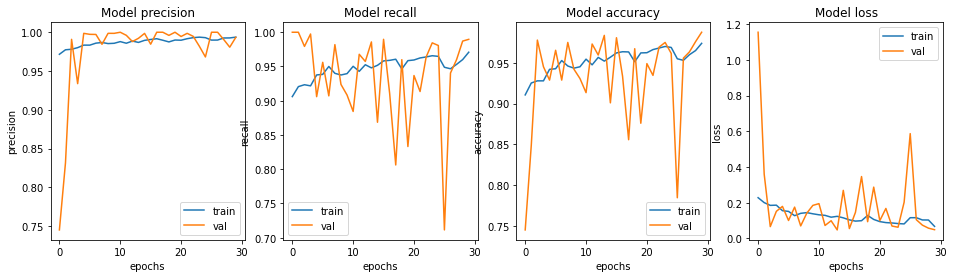

In [111]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [112]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 62ms/step - loss: 1.2583 - accuracy: 0.7756 - precision: 0.7404 - recall: 0.9872


**batch normalization만 사용한 것이 accuracy, loss가 안정적이고 recall이 더 높게 나왔다.**

# 루브릭 평가
---
1. **의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**   

    - 학습과정 시각화를 통해 accuracy, loss가 잘 수렴하는 것을 확인했다.


2. **데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**

    - 레이어를 수정하면서 성능개선을 위해 실험하였다.
     
     
3. **실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.** 

    - accuracy를 높이고, recall도 더 높일 수 있었다.

    
    
# 회고
---
## 어려웠던 점 
- 도메인 지식 부족
    - 폐렴 이미지에 대한 설명을 확인했지만, 사실 구분하기에는 어려웠다.
    
## 알게된 점 
- 데이터 불균형 처리
    - class_weight를 통해 레이블 별 가중치를 다르게 할 수 있다는 것을 배웠다.

## 다짐
- 자주 사용했던 모델이어서 금방 구현할 수 있었다. 